# Graph Network LRP 

In [1]:
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec

import sys
import torch
import numpy as np
import torch_scatter
import torchgraphs as tg

import yaml
import pandas as pd
from pathlib import Path
from munch import munchify

sys.path.append('../src/')
from infection.dataset import InfectionDataset
from utils import import_
import relevance

## Load a test graph

In [51]:
graph_in, graph_target = torch.load('test-graph.pt').values()
graph_in, graph_target

(Graph(n=20, e=72, n_shape=torch.Size([4]), e_shape=torch.Size([2]), g_shape=None),
 Graph(n=20, e=0, n_shape=torch.Size([1]), e_shape=None, g_shape=None))

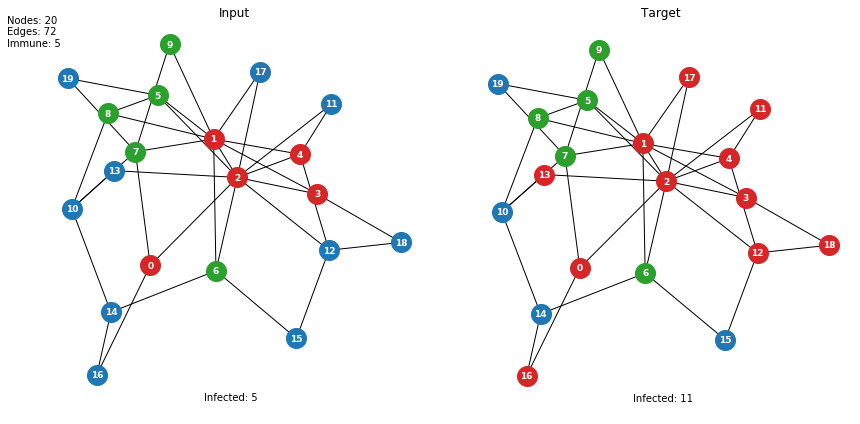

In [65]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

infected = graph_in.node_features[:,0].nonzero().view(-1).tolist()
immune = graph_in.node_features[:,1].nonzero().view(-1).tolist()
others = [i for i in range(graph_in.num_nodes) if i not in infected and i not in immune]
layout = nx.spring_layout(graph_in.to_networkx(), seed=6)

ax = axes[0]
node_ids = {i: str(i) for i in range(graph_in.num_nodes)}
nx.draw_networkx_nodes(graph_in.to_networkx(), nodelist=infected, node_size=400, node_color='C3', pos=layout, ax=ax)
nx.draw_networkx_nodes(graph_in.to_networkx(), nodelist=immune,   node_size=400, node_color='C2', pos=layout, ax=ax)
nx.draw_networkx_nodes(graph_in.to_networkx(), nodelist=others,   node_size=400, node_color='C0', pos=layout, ax=ax)
nx.draw_networkx_edges(graph_in.to_networkx().to_undirected(), pos=layout, ax=ax)
nx.draw_networkx_labels(graph_in.to_networkx(), pos=layout, labels=node_ids, ax=ax, font_size=9, font_weight='bold', font_color='white')
ax.set_title('Input')
ax.axis('off')
ax.text(-1, .6, 
        f'Nodes: {graph_in.num_nodes}\n'
        f'Edges: {graph_in.num_edges}\n'
        f'Immune: {graph_in.node_features[:,1].sum().int().item()}')
ax.text(0, -.9, f'Infected: {graph_in.node_features[:,0].sum().int().item()}')

ax = axes[1]
infected = graph_target.node_features[:,0].nonzero().view(-1).tolist()
others = [i for i in range(graph_target.num_nodes) if i not in infected and i not in immune]
nx.draw_networkx_nodes(graph_in.to_networkx(), nodelist=infected, node_size=400, node_color='C3', pos=layout, ax=ax)
nx.draw_networkx_nodes(graph_in.to_networkx(), nodelist=immune,   node_size=400, node_color='C2', pos=layout, ax=ax)
nx.draw_networkx_nodes(graph_in.to_networkx(), nodelist=others,   node_size=400, node_color='C0', pos=layout, ax=ax)
nx.draw_networkx_edges(graph_in.to_networkx().to_undirected(), pos=layout, ax=ax)
nx.draw_networkx_labels(graph_in.to_networkx(), pos=layout, labels=node_ids, ax=ax, font_size=9, font_weight='bold', font_color='white')
ax.set_title('Target')
ax.axis('off')
ax.text(0, -.9, f'Infected: {graph_target.node_features[:,0].sum().int().item()}')

fig.tight_layout()

## Import trained model

In [54]:
experiment = Path('/home/federico/experiments/infection/runs-isengard-new/full_lr.01.wd.01_NPVEML/')
with experiment.joinpath('experiment.latest.yaml').open('r') as f:
    model = munchify(yaml.safe_load(f)['model'])
model.state_dict = experiment / 'model.latest.pt'
net = import_(model.fn)(*model.args, **model.kwargs)
net.load_state_dict(torch.load(model.state_dict, map_location='cpu'))

Model parameters:

In [55]:
print(f'{net.__class__.__name__} parameters:')
for name, param in net.named_parameters():
    print(f'{name:8}', tuple(param.shape), param.detach().numpy().round(3), sep='\t')

FullGN parameters:
f_edge  	(1, 2)	[[-0.005 -0.003]]
f_sender	(1, 4)	[[ 1.52  -1.606 -0.004 -0.   ]]
f_receiver	(1, 4)	[[ 1.644e+00 -1.000e-03  3.000e-03  1.000e-03]]
f_bias  	(1,)	[0.001]
g_node  	(1, 4)	[[ 0.002 -0.    -0.001 -0.004]]
g_in    	(1, 1)	[[0.003]]
g_out   	(1, 1)	[[4.701]]
g_bias  	(1,)	[-3.768]


Forward pass:

In [56]:
import inspect
import textwrap
print(textwrap.dedent(inspect.getsource(net.forward)))

def forward(self, graphs: tg.GraphBatch):
    edges = F.relu(
        graphs.edge_features @ self.f_edge.t() +
        (graphs.node_features @ self.f_sender.t()).index_select(dim=0, index=graphs.senders) +
        (graphs.node_features @ self.f_receiver.t()).index_select(dim=0, index=graphs.receivers) +
        self.f_bias
    )
    incoming_edges_agg = (torch_scatter.scatter_max(edges, graphs.receivers, dim=0, dim_size=graphs.num_nodes)[0])
    outgoing_edges_agg = (torch_scatter.scatter_max(edges, graphs.senders, dim=0, dim_size=graphs.num_nodes)[0])
    nodes = (
            graphs.node_features @ self.g_node.t() +
            incoming_edges_agg @ self.g_in.t() +
            outgoing_edges_agg @ self.g_out.t() +
            self.g_bias
    )
    return graphs.evolve(
        node_features=nodes,
        num_edges=0,
        num_edges_by_graph=None,
        edge_features=None,
        global_features=None,
        senders=None,
        receivers=None
    )



## Make a prediction with the loaded model / a simpler function

In [66]:
graph_out = net(tg.GraphBatch.collate([graph_in]))[0]

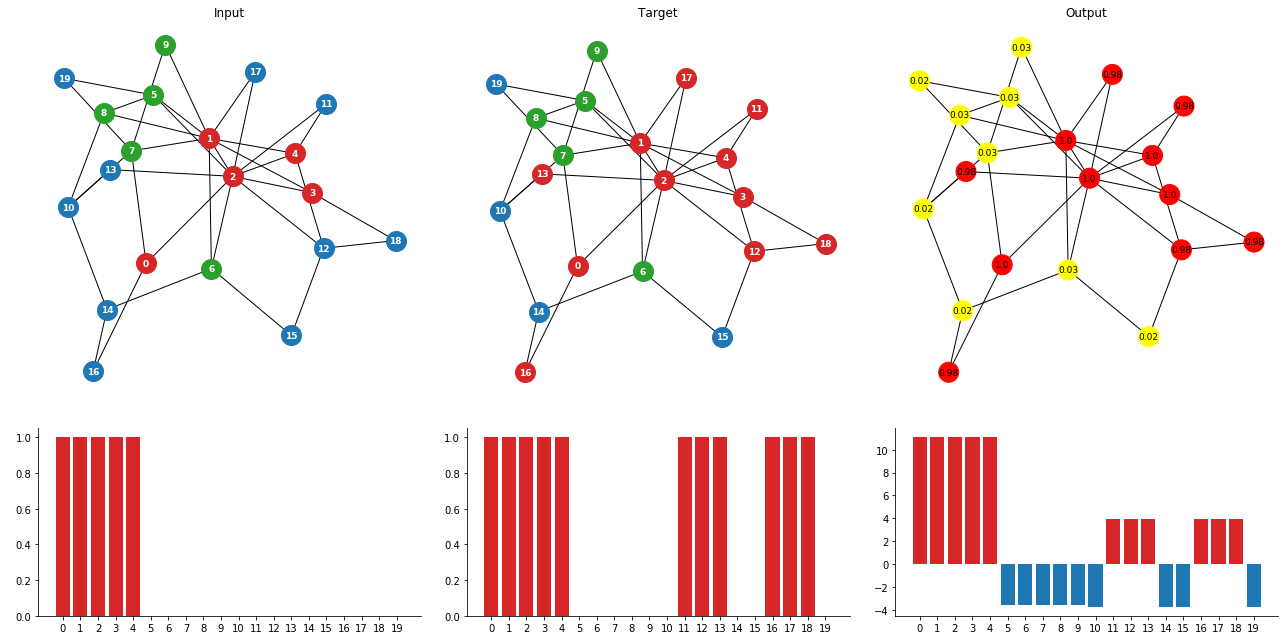

In [68]:
gs = gridspec.GridSpec(2, 3, height_ratios=[2, 1])
fig = plt.figure(figsize=(18, 9))

infected = graph_in.node_features[:,0].nonzero().view(-1).tolist()
immune = graph_in.node_features[:,1].nonzero().view(-1).tolist()
others = [i for i in range(graph_in.num_nodes) if i not in infected and i not in immune]
layout = nx.spring_layout(graph_in.to_networkx(), seed=6)

ax = fig.add_subplot(gs[0,0])
node_ids = {i: str(i) for i in range(graph_in.num_nodes)}
nx.draw_networkx_nodes(graph_in.to_networkx(), nodelist=infected, node_size=400, node_color='C3', pos=layout, ax=ax)
nx.draw_networkx_nodes(graph_in.to_networkx(), nodelist=immune,   node_size=400, node_color='C2', pos=layout, ax=ax)
nx.draw_networkx_nodes(graph_in.to_networkx(), nodelist=others,   node_size=400, node_color='C0', pos=layout, ax=ax)
nx.draw_networkx_edges(graph_in.to_networkx().to_undirected(), pos=layout, ax=ax)
nx.draw_networkx_labels(graph_in.to_networkx(), pos=layout, labels=node_ids, ax=ax, font_size=9, font_weight='bold', font_color='white')
ax.set_title('Input')
ax.axis('off')

ax = fig.add_subplot(gs[0,1])
infected = graph_target.node_features[:,0].nonzero().view(-1).tolist()
others = [i for i in range(graph_target.num_nodes) if i not in infected and i not in immune]
nx.draw_networkx_nodes(graph_in.to_networkx(), nodelist=infected, node_size=400, node_color='C3', pos=layout, ax=ax)
nx.draw_networkx_nodes(graph_in.to_networkx(), nodelist=immune,   node_size=400, node_color='C2', pos=layout, ax=ax)
nx.draw_networkx_nodes(graph_in.to_networkx(), nodelist=others,   node_size=400, node_color='C0', pos=layout, ax=ax)
nx.draw_networkx_edges(graph_in.to_networkx().to_undirected(), pos=layout, ax=ax)
nx.draw_networkx_labels(graph_in.to_networkx(), pos=layout, labels=node_ids, ax=ax, font_size=9, font_weight='bold', font_color='white')
ax.set_title('Target')
ax.axis('off')

ax = fig.add_subplot(gs[0,2])
predicted_colors = graph_out.node_features.view(-1).sigmoid().tolist()
predicted_probs = {n: l for n, l in enumerate(graph_out.node_features.sigmoid().view(-1).numpy().round(2).astype(str).tolist())}
nx.draw_networkx_nodes(graph_in.to_networkx(), node_size=400, node_color=predicted_colors, cmap='autumn_r', pos=layout, ax=ax)
nx.draw_networkx_edges(graph_in.to_networkx().to_undirected(), pos=layout, ax=ax)
nx.draw_networkx_labels(graph_in.to_networkx(), pos=layout, labels=predicted_probs, ax=ax, font_size=9)
ax.set_title('Output')
ax.axis('off')

ax = fig.add_subplot(gs[1,0])
ax.bar(torch.arange(len(graph_in.node_features)), graph_in.node_features[:,0], color='C3')
ax.set_xticks(torch.arange(len(graph_in.node_features)))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax = fig.add_subplot(gs[1,1])
ax.bar(torch.arange(len(graph_target.node_features)), graph_target.node_features.float()[:,0], color='C3')
ax.set_xticks(torch.arange(len(graph_in.node_features)))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax = fig.add_subplot(gs[1,2])
ax.bar(torch.arange(len(graph_out.node_features)), graph_out.node_features[:,0], color=['C3' if p>0 else 'C0' for p in graph_out.node_features.view(-1)])
ax.set_xticks(torch.arange(len(graph_in.node_features)))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

fig.tight_layout()

Manual prediction with relevance functions

In [72]:
# 1
sender_features_op = relevance.IndexSelect()
sender_features = sender_features_op.forward(graph_in.node_features, graph_in.senders, dim=0)

# 2
receiver_features_op = relevance.IndexSelect()
receiver_features = receiver_features_op.forward(graph_in.node_features, graph_in.receivers, dim=0)

# 3
edge_cat_op = relevance.Cat()
edge_cat = edge_cat_op.forward(graph_in.edge_features, sender_features, receiver_features, dim=1)

# 4
edge_dense_op = relevance.Dense(W=torch.cat([net.f_edge, net.f_sender, net.f_receiver], dim=1), b=net.f_bias)
new_edge_features = edge_dense_op.forward(edge_cat).clamp(min=0)

# 5
incoming_edges_agg_op = relevance.ScatterMax()
incoming_edges_agg = incoming_edges_agg_op.forward(new_edge_features, graph_in.receivers, dim=0, dim_size=graph_in.num_nodes)[0]

# 6
outgoing_edges_agg_op = relevance.ScatterMax()
outgoing_edges_agg = outgoing_edges_agg_op.forward(new_edge_features, graph_in.senders, dim=0, dim_size=graph_in.num_nodes)[0]

# 7
node_cat_op = relevance.Cat()
node_cat = node_cat_op.forward(graph_in.node_features, incoming_edges_agg, outgoing_edges_agg, dim=1)

# 8
node_dense_op = relevance.Dense(W=torch.cat([net.g_node, net.g_in, net.g_out], dim=1), b=net.g_bias)
new_node_features = node_dense_op.forward(node_cat)

pd.DataFrame({
    'target': graph_target.node_features.squeeze().int(), 
    'net_pred':graph_out.node_features.sigmoid().squeeze().numpy().round(2), 
    'manual_pred': new_node_features.sigmoid().squeeze().numpy().round(2)}
).transpose()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
target,1.0,1.0,1.0,1.0,1.0,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00,0.00,0.00,1.00,1.00,1.00,0.00
net_pred,1.0,1.0,1.0,1.0,1.0,0.03,0.03,0.03,0.03,0.03,0.02,0.98,0.98,0.98,0.02,0.02,0.98,0.98,0.98,0.02
manual_pred,1.0,1.0,1.0,1.0,1.0,0.03,0.03,0.03,0.03,0.03,0.02,0.98,0.98,0.98,0.02,0.02,0.98,0.98,0.98,0.02


## Explain node 16 that was healty and is now infected

In [73]:
N = 16
new_node_relevance = torch.zeros_like(new_node_features)
new_node_relevance[N] = new_node_features[N]

In [74]:
# 8
node_cat_relevance = node_dense_op.relevance(new_node_relevance)

# 7
node_features_relevance, incoming_edges_agg_relevance, outgoing_edges_agg_relevance = \
    node_cat_op.relevance(node_cat_relevance)

# 6 and 5
new_edge_features_relevance = (
    outgoing_edges_agg_op.relevance(outgoing_edges_agg_relevance) +
    incoming_edges_agg_op.relevance(incoming_edges_agg_relevance)
)

# 4
edge_cat_relevance = edge_dense_op.relevance(new_edge_features_relevance)

# 3
edge_features_relevance, sender_features_relevance, receiver_features_relevance = edge_cat_op.relevance(edge_cat_relevance)

# 2 and 1
node_features_relevance = (
    node_features_relevance +
    receiver_features_op.relevance(receiver_features_relevance) +
    sender_features_op.relevance(sender_features_relevance)
)

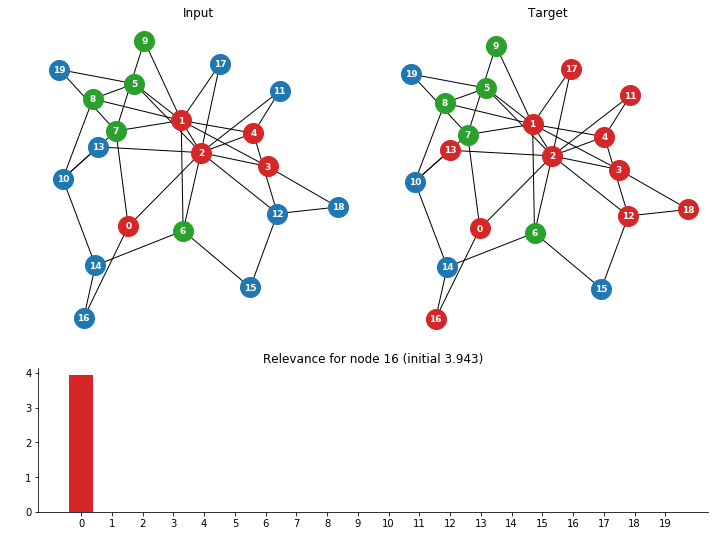

In [87]:
fig = plt.figure(figsize=(12, 9))

infected = graph_in.node_features[:,0].nonzero().view(-1).tolist()
immune = graph_in.node_features[:,1].nonzero().view(-1).tolist()
others = [i for i in range(graph_in.num_nodes) if i not in infected and i not in immune]
layout = nx.spring_layout(graph_in.to_networkx(), seed=6)

ax = plt.subplot2grid((3,4), loc=(0,0), rowspan=2, colspan=2 ,fig=fig)
node_ids = {i: str(i) for i in range(graph_in.num_nodes)}
nx.draw_networkx_nodes(graph_in.to_networkx(), nodelist=infected, node_size=400, node_color='C3', pos=layout, ax=ax)
nx.draw_networkx_nodes(graph_in.to_networkx(), nodelist=immune,   node_size=400, node_color='C2', pos=layout, ax=ax)
nx.draw_networkx_nodes(graph_in.to_networkx(), nodelist=others,   node_size=400, node_color='C0', pos=layout, ax=ax)
nx.draw_networkx_edges(graph_in.to_networkx().to_undirected(), pos=layout, ax=ax)
nx.draw_networkx_labels(graph_in.to_networkx(), pos=layout, labels=node_ids, ax=ax, font_size=9, font_weight='bold', font_color='white')
ax.set_title('Input')
ax.axis('off')

ax = plt.subplot2grid((3,4), loc=(0,2), rowspan=2, colspan=2 ,fig=fig)
infected = graph_target.node_features[:,0].nonzero().view(-1).tolist()
others = [i for i in range(graph_target.num_nodes) if i not in infected and i not in immune]
nx.draw_networkx_nodes(graph_in.to_networkx(), nodelist=infected, node_size=400, node_color='C3', pos=layout, ax=ax)
nx.draw_networkx_nodes(graph_in.to_networkx(), nodelist=immune,   node_size=400, node_color='C2', pos=layout, ax=ax)
nx.draw_networkx_nodes(graph_in.to_networkx(), nodelist=others,   node_size=400, node_color='C0', pos=layout, ax=ax)
nx.draw_networkx_edges(graph_in.to_networkx().to_undirected(), pos=layout, ax=ax)
nx.draw_networkx_labels(graph_in.to_networkx(), pos=layout, labels=node_ids, ax=ax, font_size=9, font_weight='bold', font_color='white')
ax.set_title('Target')
ax.axis('off')

ax = plt.subplot2grid((3,4), loc=(2,0), colspan=4 ,fig=fig)
ax.bar(torch.arange(graph_in.num_nodes), node_features_relevance.sum(dim=1), color='C3')
ax.set_xticks(torch.arange(graph_in.num_nodes))
ax.set_title(f'Relevance for node {N} (initial {new_node_relevance[N].item():.3f})')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

## Explain node 17 that was healty and is now infected (from 1 and 2)

In [88]:
N = 17
new_node_relevance = torch.zeros_like(new_node_features)
new_node_relevance[N] = new_node_features[N]

In [89]:
# 8
node_cat_relevance = node_dense_op.relevance(new_node_relevance)

# 7
node_features_relevance, incoming_edges_agg_relevance, outgoing_edges_agg_relevance = \
    node_cat_op.relevance(node_cat_relevance)

# 6 and 5
new_edge_features_relevance = (
    outgoing_edges_agg_op.relevance(outgoing_edges_agg_relevance) +
    incoming_edges_agg_op.relevance(incoming_edges_agg_relevance)
)

# 4
edge_cat_relevance = edge_dense_op.relevance(new_edge_features_relevance)

# 3
edge_features_relevance, sender_features_relevance, receiver_features_relevance = edge_cat_op.relevance(edge_cat_relevance)

# 2 and 1
node_features_relevance = (
    node_features_relevance +
    receiver_features_op.relevance(receiver_features_relevance) +
    sender_features_op.relevance(sender_features_relevance)
)

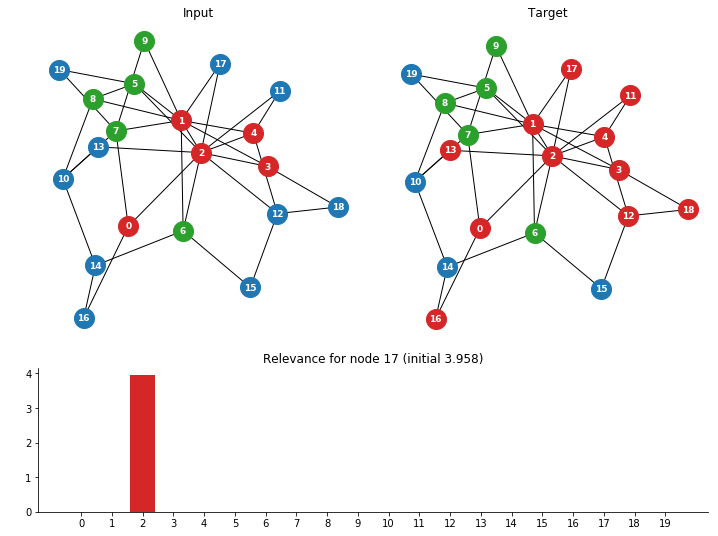

In [90]:
fig = plt.figure(figsize=(12, 9))

infected = graph_in.node_features[:,0].nonzero().view(-1).tolist()
immune = graph_in.node_features[:,1].nonzero().view(-1).tolist()
others = [i for i in range(graph_in.num_nodes) if i not in infected and i not in immune]
layout = nx.spring_layout(graph_in.to_networkx(), seed=6)

ax = plt.subplot2grid((3,4), loc=(0,0), rowspan=2, colspan=2 ,fig=fig)
node_ids = {i: str(i) for i in range(graph_in.num_nodes)}
nx.draw_networkx_nodes(graph_in.to_networkx(), nodelist=infected, node_size=400, node_color='C3', pos=layout, ax=ax)
nx.draw_networkx_nodes(graph_in.to_networkx(), nodelist=immune,   node_size=400, node_color='C2', pos=layout, ax=ax)
nx.draw_networkx_nodes(graph_in.to_networkx(), nodelist=others,   node_size=400, node_color='C0', pos=layout, ax=ax)
nx.draw_networkx_edges(graph_in.to_networkx().to_undirected(), pos=layout, ax=ax)
nx.draw_networkx_labels(graph_in.to_networkx(), pos=layout, labels=node_ids, ax=ax, font_size=9, font_weight='bold', font_color='white')
ax.set_title('Input')
ax.axis('off')

ax = plt.subplot2grid((3,4), loc=(0,2), rowspan=2, colspan=2 ,fig=fig)
infected = graph_target.node_features[:,0].nonzero().view(-1).tolist()
others = [i for i in range(graph_target.num_nodes) if i not in infected and i not in immune]
nx.draw_networkx_nodes(graph_in.to_networkx(), nodelist=infected, node_size=400, node_color='C3', pos=layout, ax=ax)
nx.draw_networkx_nodes(graph_in.to_networkx(), nodelist=immune,   node_size=400, node_color='C2', pos=layout, ax=ax)
nx.draw_networkx_nodes(graph_in.to_networkx(), nodelist=others,   node_size=400, node_color='C0', pos=layout, ax=ax)
nx.draw_networkx_edges(graph_in.to_networkx().to_undirected(), pos=layout, ax=ax)
nx.draw_networkx_labels(graph_in.to_networkx(), pos=layout, labels=node_ids, ax=ax, font_size=9, font_weight='bold', font_color='white')
ax.set_title('Target')
ax.axis('off')

ax = plt.subplot2grid((3,4), loc=(2,0), colspan=4 ,fig=fig)
ax.bar(torch.arange(graph_in.num_nodes), node_features_relevance.sum(dim=1), color='C3')
ax.set_xticks(torch.arange(graph_in.num_nodes))
ax.set_title(f'Relevance for node {N} (initial {new_node_relevance[N].item():.3f})')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

## Explain node 10 that was healty and still is

In [91]:
N = 10
new_node_relevance = torch.zeros_like(new_node_features)
new_node_relevance[N] = new_node_features[N]

In [92]:
# 8
node_cat_relevance = node_dense_op.relevance(new_node_relevance)

# 7
node_features_relevance, incoming_edges_agg_relevance, outgoing_edges_agg_relevance = \
    node_cat_op.relevance(node_cat_relevance)

# 6 and 5
new_edge_features_relevance = (
    outgoing_edges_agg_op.relevance(outgoing_edges_agg_relevance) +
    incoming_edges_agg_op.relevance(incoming_edges_agg_relevance)
)

# 4
edge_cat_relevance = edge_dense_op.relevance(new_edge_features_relevance)

# 3
edge_features_relevance, sender_features_relevance, receiver_features_relevance = edge_cat_op.relevance(edge_cat_relevance)

# 2 and 1
node_features_relevance = (
    node_features_relevance +
    receiver_features_op.relevance(receiver_features_relevance) +
    sender_features_op.relevance(sender_features_relevance)
)

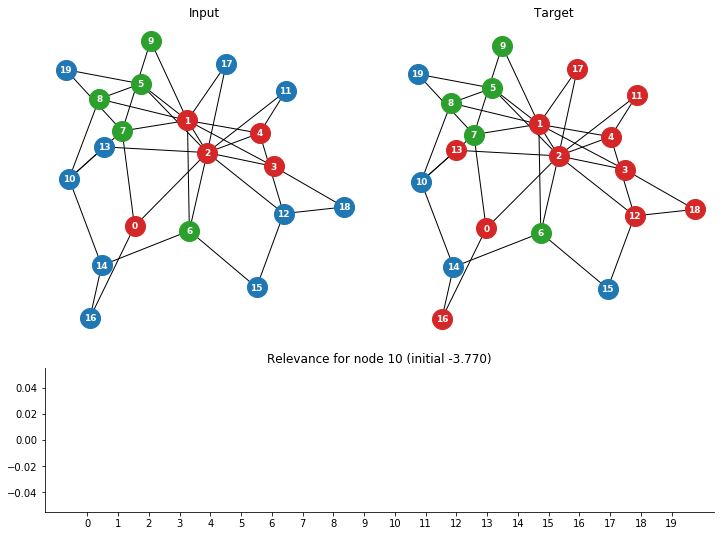

In [93]:
fig = plt.figure(figsize=(12, 9))

infected = graph_in.node_features[:,0].nonzero().view(-1).tolist()
immune = graph_in.node_features[:,1].nonzero().view(-1).tolist()
others = [i for i in range(graph_in.num_nodes) if i not in infected and i not in immune]
layout = nx.spring_layout(graph_in.to_networkx(), seed=6)

ax = plt.subplot2grid((3,4), loc=(0,0), rowspan=2, colspan=2 ,fig=fig)
node_ids = {i: str(i) for i in range(graph_in.num_nodes)}
nx.draw_networkx_nodes(graph_in.to_networkx(), nodelist=infected, node_size=400, node_color='C3', pos=layout, ax=ax)
nx.draw_networkx_nodes(graph_in.to_networkx(), nodelist=immune,   node_size=400, node_color='C2', pos=layout, ax=ax)
nx.draw_networkx_nodes(graph_in.to_networkx(), nodelist=others,   node_size=400, node_color='C0', pos=layout, ax=ax)
nx.draw_networkx_edges(graph_in.to_networkx().to_undirected(), pos=layout, ax=ax)
nx.draw_networkx_labels(graph_in.to_networkx(), pos=layout, labels=node_ids, ax=ax, font_size=9, font_weight='bold', font_color='white')
ax.set_title('Input')
ax.axis('off')

ax = plt.subplot2grid((3,4), loc=(0,2), rowspan=2, colspan=2 ,fig=fig)
infected = graph_target.node_features[:,0].nonzero().view(-1).tolist()
others = [i for i in range(graph_target.num_nodes) if i not in infected and i not in immune]
nx.draw_networkx_nodes(graph_in.to_networkx(), nodelist=infected, node_size=400, node_color='C3', pos=layout, ax=ax)
nx.draw_networkx_nodes(graph_in.to_networkx(), nodelist=immune,   node_size=400, node_color='C2', pos=layout, ax=ax)
nx.draw_networkx_nodes(graph_in.to_networkx(), nodelist=others,   node_size=400, node_color='C0', pos=layout, ax=ax)
nx.draw_networkx_edges(graph_in.to_networkx().to_undirected(), pos=layout, ax=ax)
nx.draw_networkx_labels(graph_in.to_networkx(), pos=layout, labels=node_ids, ax=ax, font_size=9, font_weight='bold', font_color='white')
ax.set_title('Target')
ax.axis('off')

ax = plt.subplot2grid((3,4), loc=(2,0), colspan=4 ,fig=fig)
ax.bar(torch.arange(graph_in.num_nodes), node_features_relevance.sum(dim=1), color='C3')
ax.set_xticks(torch.arange(graph_in.num_nodes))
ax.set_title(f'Relevance for node {N} (initial {new_node_relevance[N].item():.3f})')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

## Explain node 6 that was immune

In [94]:
N = 6
new_node_relevance = torch.zeros_like(new_node_features)
new_node_relevance[N] = new_node_features[N]

In [95]:
# 8
node_cat_relevance = node_dense_op.relevance(new_node_relevance)

# 7
node_features_relevance, incoming_edges_agg_relevance, outgoing_edges_agg_relevance = \
    node_cat_op.relevance(node_cat_relevance)

# 6 and 5
new_edge_features_relevance = (
    outgoing_edges_agg_op.relevance(outgoing_edges_agg_relevance) +
    incoming_edges_agg_op.relevance(incoming_edges_agg_relevance)
)

# 4
edge_cat_relevance = edge_dense_op.relevance(new_edge_features_relevance)

# 3
edge_features_relevance, sender_features_relevance, receiver_features_relevance = edge_cat_op.relevance(edge_cat_relevance)

# 2 and 1
node_features_relevance = (
    node_features_relevance +
    receiver_features_op.relevance(receiver_features_relevance) +
    sender_features_op.relevance(sender_features_relevance)
)

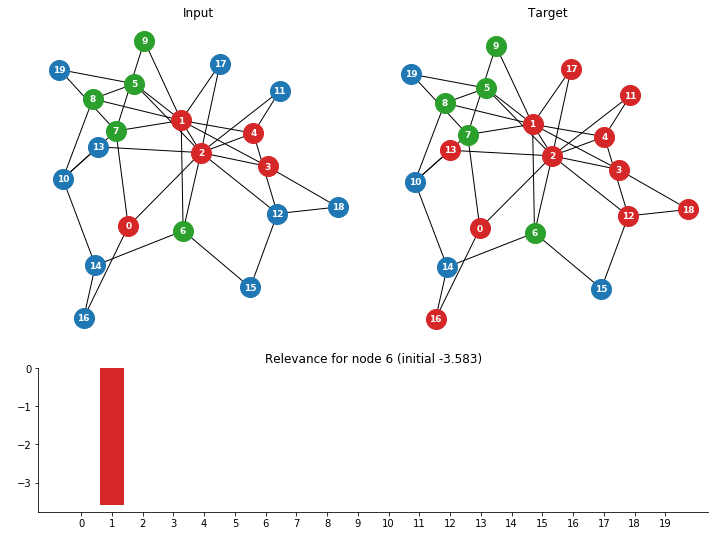

In [96]:
fig = plt.figure(figsize=(12, 9))

infected = graph_in.node_features[:,0].nonzero().view(-1).tolist()
immune = graph_in.node_features[:,1].nonzero().view(-1).tolist()
others = [i for i in range(graph_in.num_nodes) if i not in infected and i not in immune]
layout = nx.spring_layout(graph_in.to_networkx(), seed=6)

ax = plt.subplot2grid((3,4), loc=(0,0), rowspan=2, colspan=2 ,fig=fig)
node_ids = {i: str(i) for i in range(graph_in.num_nodes)}
nx.draw_networkx_nodes(graph_in.to_networkx(), nodelist=infected, node_size=400, node_color='C3', pos=layout, ax=ax)
nx.draw_networkx_nodes(graph_in.to_networkx(), nodelist=immune,   node_size=400, node_color='C2', pos=layout, ax=ax)
nx.draw_networkx_nodes(graph_in.to_networkx(), nodelist=others,   node_size=400, node_color='C0', pos=layout, ax=ax)
nx.draw_networkx_edges(graph_in.to_networkx().to_undirected(), pos=layout, ax=ax)
nx.draw_networkx_labels(graph_in.to_networkx(), pos=layout, labels=node_ids, ax=ax, font_size=9, font_weight='bold', font_color='white')
ax.set_title('Input')
ax.axis('off')

ax = plt.subplot2grid((3,4), loc=(0,2), rowspan=2, colspan=2 ,fig=fig)
infected = graph_target.node_features[:,0].nonzero().view(-1).tolist()
others = [i for i in range(graph_target.num_nodes) if i not in infected and i not in immune]
nx.draw_networkx_nodes(graph_in.to_networkx(), nodelist=infected, node_size=400, node_color='C3', pos=layout, ax=ax)
nx.draw_networkx_nodes(graph_in.to_networkx(), nodelist=immune,   node_size=400, node_color='C2', pos=layout, ax=ax)
nx.draw_networkx_nodes(graph_in.to_networkx(), nodelist=others,   node_size=400, node_color='C0', pos=layout, ax=ax)
nx.draw_networkx_edges(graph_in.to_networkx().to_undirected(), pos=layout, ax=ax)
nx.draw_networkx_labels(graph_in.to_networkx(), pos=layout, labels=node_ids, ax=ax, font_size=9, font_weight='bold', font_color='white')
ax.set_title('Target')
ax.axis('off')

ax = plt.subplot2grid((3,4), loc=(2,0), colspan=4 ,fig=fig)
ax.bar(torch.arange(graph_in.num_nodes), node_features_relevance.sum(dim=1), color='C3')
ax.set_xticks(torch.arange(graph_in.num_nodes))
ax.set_title(f'Relevance for node {N} (initial {new_node_relevance[N].item():.3f})')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)